# Machine Learning Models For Solar Cost Datasets

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
import pandas as pd
import tensorflow as tf
import numpy as np

# import xgboost dependencies
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from lightgbm import LGBMRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance

# import pickle for saving the models
import pickle

# disable the gpu on mac_m2 so it runs correctly
# https://github.com/keras-team/tf-keras/issues/140
# https://github.com/tensorflow/tensorflow/issues/62361
hw = tf.config.get_visible_devices()
tf.config.set_visible_devices(hw[0])

In [2]:
# import the Utility dataset
utility = 'SDGE'
#data_file = "clean_data/df_" + utility + ".csv"
data_file = "/Users/ns96/Documents/ML_Project/df_" + utility + ".csv"

utility_df = pd.read_csv(data_file)
print(utility_df.shape)
utility_df.head()

(85620, 19)


,Utility,Service_City,Service_Zip,Service_County,Technology_Type,System_Size_AC,Storage_Size_kW_AC,Inverter_Size_kW_AC,Mounting_Method,App_Received_Date,Installer_Name,Third_Party_Owned,Electric_Vehicle,Total_System_Cost,Generator_Manufacturer,Inverter_Manufacturer,Generator_Quantity,Inverter_Quantity,Year
0,SDGE,SAN DIEGO,92105,SAN DIEGO,Solar,3.676,0.0,3.800,Rooftop,2019-02-14,Tesla,No,No,21709.0,Kyocera,ABB,16.0,1.0,2019
1,SDGE,SAN DIEGO,92110,SAN DIEGO,Solar,7.639,0.0,5.052,Rooftop,2019-09-24,Self-installed,No,No,38000.0,Hanwha,SolarEdge,24.0,1.0,2019
2,SDGE,LEMON GROVE,91945,SAN DIEGO,Solar,4.760,0.0,15.000,Rooftop,2018-11-30,Self-installed,No,No,18000.0,Other,SunPower,24.0,12.0,2018
3,SDGE,LA MESA,91941,SAN DIEGO,Solar,6.776,0.0,7.616,Rooftop,2018-01-17,Self-installed,No,No,22000.0,LG,SolarEdge,22.0,1.0,2018
4,SDGE,SAN DIEGO,92130,SAN DIEGO,Solar,4.320,0.0,3.747,Rooftop,2018-01-26,Semper,No,No,15962.0,Sanyo,SolarEdge,28.0,1.0,2018


In [3]:
# lets see what values of total cost are
utility_df.Total_System_Cost.describe()

count    8.562000e+04
mean     2.956006e+04
std      2.708759e+04
min      7.000000e+03
25%      1.718300e+04
50%      2.476300e+04
75%      3.570000e+04
max      2.976760e+06
Name: Total_System_Cost, dtype: float64

In [ ]:
# reduce the number of cities i.e if less than 200 then just set it to other
city_counts = utility_df.Service_City.value_counts().to_dict()

def check_count(city):
    if city_counts[city] >= 200:
        return city
    else:
        return 'Other'

utility_df['Service_City'] = utility_df['Service_City'].apply(check_count)

In [ ]:
utility_df['Service_City'].value_counts()

In [ ]:
# convert zip code to string
utility_df['Service_Zip'] = utility_df['Service_Zip'].astype(int).astype(str).str.zfill(5)
utility_df.info()

In [ ]:
# see how many installers, cities, and zip codes we have
print("Zipcodes:", utility_df.Service_Zip.nunique())
print("Cities:", utility_df.Service_City.nunique())
print("Installers:", utility_df.Installer_Name.nunique())
print("Generator Manufacturer:", utility_df.Generator_Manufacturer.nunique())

In [4]:
#for now lest drop some columns to make model perform better?
#columns_to_drop = ['Utility', 'Service_Zip', 'Service_County', 'App_Received_Date', 'Inverter_Size_kW_AC', 
#                   'Generator_Manufacturer', 'Inverter_Manufacturer', 'Inverter_Quantity', 'Year']

# Used when training on the entire dataset
#columns_to_drop = ['Service_Zip', 'Service_County', 'App_Received_Date', 'Inverter_Size_kW_AC', 
#                   'Inverter_Manufacturer', 'Inverter_Quantity', 'Year']

columns_to_drop = ['Utility', 'Service_Zip', 'Service_County', 'App_Received_Date', 'Inverter_Size_kW_AC', 
                   'Inverter_Manufacturer', 'Inverter_Quantity', 'Year']

#columns_to_drop = ['Utility', 'Service_Zip', 'App_Received_Date']
#columns_to_drop = ['Utility', 'Service_City', 'App_Received_Date']
#columns_to_drop = ['Utility', 'App_Received_Date']
#columns_to_drop = ['Utility', 'Service_Zip', 'App_Received_Date', 'Inverter_Size_kW_AC']

utility_df.drop(columns=columns_to_drop, inplace=True)
utility_df.head()

,Service_City,Technology_Type,System_Size_AC,Storage_Size_kW_AC,Mounting_Method,Installer_Name,Third_Party_Owned,Electric_Vehicle,Total_System_Cost,Generator_Manufacturer,Generator_Quantity
0,SAN DIEGO,Solar,3.676,0.0,Rooftop,Tesla,No,No,21709.0,Kyocera,16.0
1,SAN DIEGO,Solar,7.639,0.0,Rooftop,Self-installed,No,No,38000.0,Hanwha,24.0
2,LEMON GROVE,Solar,4.760,0.0,Rooftop,Self-installed,No,No,18000.0,Other,24.0
3,LA MESA,Solar,6.776,0.0,Rooftop,Self-installed,No,No,22000.0,LG,22.0
4,SAN DIEGO,Solar,4.320,0.0,Rooftop,Semper,No,No,15962.0,Sanyo,28.0


In [ ]:
# print out column names
utility_df.columns.to_list()

In [5]:
# Convert categorical data to numeric with `pd.get_dummies`
cat_columns = utility_df.dtypes[utility_df.dtypes == "object"].index.tolist()

enc = OneHotEncoder(sparse_output=False)
enc_data = enc.fit_transform(utility_df[cat_columns])
enc_columns = enc.get_feature_names_out().tolist()

encode_df = pd.DataFrame(enc_data, columns=enc_columns)
#display(encode_df.head())

# now lets merge the into the application dataframe then drop original columns
utility_df = utility_df.merge(encode_df, left_index=True, right_index=True)
utility_df = utility_df.drop(columns=cat_columns)

print(utility_df.columns)

utility_df.head()

Index(['System_Size_AC', 'Storage_Size_kW_AC', 'Total_System_Cost',
       'Generator_Quantity', 'Service_City_ALPINE', 'Service_City_BONITA',
       'Service_City_BONSALL', 'Service_City_BORREGO SPRINGS',
       'Service_City_BOULEVARD', 'Service_City_CAMPO',
       ...
       'Generator_Manufacturer_Sharp', 'Generator_Manufacturer_Silfab',
       'Generator_Manufacturer_SolarWorld', 'Generator_Manufacturer_Solaria',
       'Generator_Manufacturer_SunEdison', 'Generator_Manufacturer_SunPower',
       'Generator_Manufacturer_Sunspark', 'Generator_Manufacturer_Tesla',
       'Generator_Manufacturer_Trina', 'Generator_Manufacturer_Yingli Energy'],
      dtype='object', length=153)


,System_Size_AC,Storage_Size_kW_AC,Total_System_Cost,Generator_Quantity,Service_City_ALPINE,Service_City_BONITA,Service_City_BONSALL,Service_City_BORREGO SPRINGS,Service_City_BOULEVARD,Service_City_CAMPO,...,Generator_Manufacturer_Sharp,Generator_Manufacturer_Silfab,Generator_Manufacturer_SolarWorld,Generator_Manufacturer_Solaria,Generator_Manufacturer_SunEdison,Generator_Manufacturer_SunPower,Generator_Manufacturer_Sunspark,Generator_Manufacturer_Tesla,Generator_Manufacturer_Trina,Generator_Manufacturer_Yingli Energy
0,3.676,0.0,21709.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.639,0.0,38000.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.760,0.0,18000.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.776,0.0,22000.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.320,0.0,15962.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Split our preprocessed data into our features and target arrays
y = utility_df['Total_System_Cost']
X = utility_df.drop(columns='Total_System_Cost')

## Test the affect of using different random_state values has on the r2

In [ ]:
%%time

best_state = -1;
best_r2 = 0
best_mae = 0

for i in range(1000):
    print("Testing Random State", i)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=i)

    # scale the data
    # Fit the StandardScaler
    scaler = StandardScaler()
    X_scaler = scaler.fit(X_train)

    # Scale the data
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    model = xgb.XGBRegressor(max_depth=10, n_estimators=100, learning_rate = 0.07, reg_alpha=1, subsample = 0.8, colsample_bytree=0.9)                     
    #model = GradientBoostingRegressor()
    #model = RandomForestRegressor(n_jobs = -1)
    #model = LGBMRegressor(metric='mae', n_estimators=50, num_leaves=256, bagging_freq=1, learning_rate = 0.07, reg_alpha=1, subsample = 0.8, colsample_bytree=0.5)
    model.fit(X_train, y_train)

    #Making predictions on the test set
    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    print("Root Mean Squared Error:", rmse)
    print("Mean Absolute Error:", mae)
    print("R-squared Score:", r2)
    print()

    if r2 > best_r2:
        best_state = i
        best_r2 = r2
        best_mae = mae

# print out the best r2 so far
print("\n------------------------------")
print("Best Random State:", best_state)
print("Best Mean Absolute Error:", best_mae)
print("Best R-squared Score:", best_r2)

In [7]:
# Split the preprocessed data into a training and testing dataset
# split on 397 for PGE out of 1000  => 0.81%
# split on 865 for SDGE out of 1000 => 0.80%
# split on 269 for SCE out of 1000  => 0.756%
# split on 358 for Full-ML out of 1000 => 0.735
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=865)

In [8]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# set the number of features
number_input_features = X_train.shape[1]
number_input_records = X_train.shape[0]

print("Number of Input Features:", number_input_features)
print("Number of Input Records:", number_input_records)

Number of Input Features: 152
Number of Input Records: 59934


In [9]:
#Basic model Creating an XGBoost regressor
model = xgb.XGBRegressor(max_depth=10, n_estimators=100, learning_rate = 0.07, reg_alpha=1, subsample = 0.8, colsample_bytree=0.9)
                         
#model = RandomForestRegressor(n_jobs = -1)

#model = LGBMRegressor(metric='mae')
#model = LGBMRegressor(metric='mae', n_estimators=500, num_leaves = 32, bagging_freq=1, learning_rate = 0.01, reg_alpha=1, subsample = 0.8, colsample_bytree=0.5)

#Training the model on the training data
model.fit(X_train_scaled, y_train)

#Making predictions on the test set
predictions = model.predict(X_test_scaled)

In [10]:
# Calculate the mean squared error and R-squared score
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r2)

Root Mean Squared Error: 13803.279890085021
Mean Absolute Error: 7135.698821638915
R-squared Score: 0.8060860398520635


In [48]:
# specify model and parameter range for grid search CV
# https://www.kaggle.com/code/jayatou/xgbregressor-with-gridsearchcv
# https://github.com/albertkklam/XGBRegressor/blob/master/XGBRegressor.ipynb
estimator = xgb.XGBRegressor(
    objective= 'reg:squarederror',
    colsample_bytree = 0.9,
    reg_alpha = 1,
    seed=42
)

parameters = {
    'max_depth': range (6, 10, 1),
    'n_estimators': range(50, 300, 25),
    'learning_rate': [0.1, 0.07, 0.05, 0.03],
    'subsample': [0.5, 0.7, 0.9]
}

# specify the grid search object
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'r2',
    n_jobs = -1,
    cv = 3,
    verbose=True
)

In [49]:
%%time
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


/opt/homebrew/Caskroom/miniforge/base/envs/tf-gpu/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 30.3 s, sys: 19.2 s, total: 49.5 s
Wall time: 19min 49s


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.9,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, ma...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.07, 0.05, 0.03],
                         'max_depth': range(6, 10),
                         'n_estimators': range(50, 300, 25),
                         'subsample': [0.5, 0.7, 0.9]},
             scoring='r2', verbose=True)

In [50]:
# see the best parameters https://www.projectpro.io/recipes/find-optimal-parameters-using-gridsearchcv
print(" Results from Grid Search")
print("\n The best estimator across ALL searched params:\n", grid_search.best_estimator_)
print("\n The best score across ALL searched params:\n", grid_search.best_score_)
print("\n The best parameters across ALL searched params:\n", grid_search.best_params_)

 Results from Grid Search

 The best estimator across ALL searched params:
 XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=275, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

 The best score across ALL searched params:
 0.6356834144363911

 The best parameters across ALL searched params:
 {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 275, 'subs

In [51]:
# Calculate the mean squared error and R-squared score
model = grid_search.best_estimator_
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r2)

Root Mean Squared Error: 9997.68455976775
Mean Absolute Error: 5136.125441919022
R-squared Score: 0.7610416785226142


<BarContainer object of 20 artists>

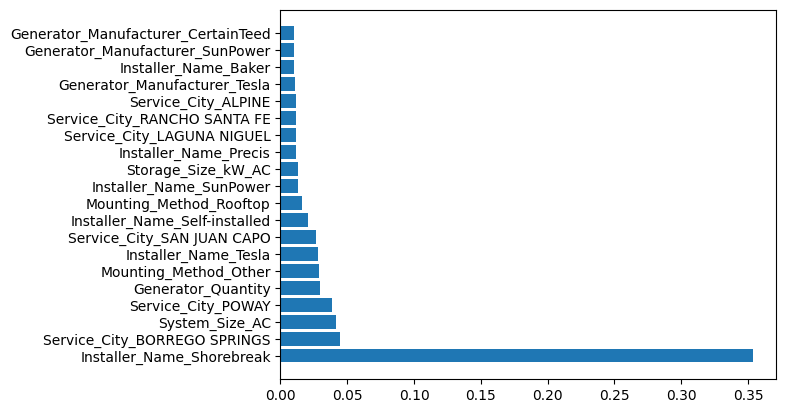

In [11]:
# plot feature importance
n_top_features = 20
sorted_idx = model.feature_importances_.argsort()[::-1]

top_features = X_test.columns[sorted_idx][:n_top_features ].tolist()

plt.barh(X_test.columns[sorted_idx][:n_top_features ], model.feature_importances_[sorted_idx][:n_top_features ])

In [12]:
# save the scaler and model for future use
scaler_file = "models/scaler-" + utility + ".pkl"
model_file = "models/xgb_model-" + utility + ".pkl"

pickle.dump(scaler, open(scaler_file, "wb"))
pickle.dump(model, open(model_file, "wb"))

# to reopen use
#scaler = pickle.load(open(scaler_file, "rb"))
#model = pickle.load(open(model_file, "rb"))

## Test a Neural Network Model

In [ ]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
hidden_nodes_layer1 = number_input_features*2
hidden_nodes_layer2 = number_input_features
hidden_nodes_layer3 = int(number_input_features/3)
activation_function = 'relu'

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation=activation_function))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="linear"))

# Check the structure of the model
nn.summary()

In [ ]:
# compile the model
nn.compile(loss='mae', optimizer='rmsprop', metrics=['mse','mae'])

In [ ]:
# Train the model
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

fit_model = nn.fit(X_train_scaled, y_train, epochs=500, batch_size=128, callbacks=[earlyStop])
#fit_model = nn.fit(X_train_scaled, y_train, epochs=100,  batch_size=16)

In [ ]:
#Making predictions on the test set
predictions = nn.predict(X_test_scaled)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, predictions)
#metric = tf.keras.metrics.R2Score()
#metric.update_state(y_test.to_numpy().reshape(-1,1), predictions)
#r2 = metric.result()

print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r2)